In [1]:
import psycopg2
import pandas as pd
import numpy as np
import mariadb
import json
import os
import shutil
import subprocess
from pathlib import Path
import pyodbc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [3]:
analysisDetails = pd.read_csv("output/analysis_chemicals.csv")
analysisDetails.analysis_name = [ i.replace(":","") for i in analysisDetails.analysis_name ]
analysisDetails['chemical_name'] = [ i.replace("'","").replace("[","").replace("]","").split(",") for i in analysisDetails['chemical_name'] ]
analysisDetails = analysisDetails.set_index("analysis_name")
analysisDetails = analysisDetails.to_dict()['chemical_name']


In [15]:
analysisDetails['% Organic Matter (OM)'] = analysisDetails['Organic Matter % (OM)']

In [7]:
soil_df = pd.read_csv("output/soil_analysis_cleaned.csv")

In [9]:
soil_df

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0        sample_code  \
0                5708          3457        3457    FA611-161SA0001   
1                5858          3532        3532    FA807-384SA0001   
2                7053          4311        4311        CC004SA0484   
3                8124          5056        5056        CC004SA0485   
4               13057          7262        7262    FA807-384SA0002   
...               ...           ...         ...                ...   
4039424       5423691       3703954     3703954  CA266SA2510         
4039425       5423793       3704000     3704000  CA266SA2511         
4039426       4587318       3110973     3110973        CW153SA0001   
4039427       4587321       3110974     3110974        CW153SA0001   
4039428       4587324       3110975     3110975        CW153SA0001   

                      batch_date                                analysis_name  \
0        2019-04-29 00:00:00.000  Complete Soil Analysis with Recommendations   
1        2019-10-30 00:00:00.000  Complete Soil Analysis with Recommendations   
2        2019-05-06 00:00:00.000  Complete Soil Analysis with Recommendations   
3        2019-05-06 00:00:00.000  Complete Soil Analysis with Recommendations   
4        2019-10-30 00:00:00.000  Complete Soil Analysis with Recommendations   
...                          ...                                          ...   
4039424  2024-06-13 16:08:00.000     Standard Soil Health Analysis (Alkaline)   
4039425  2024-06-13 16:08:00.000     Standard Soil Health Analysis (Alkaline)   
4039426  2021-08-20 15:30:00.000                               Cobalt in Soil   
4039427  2021-08-20 15:30:00.000                               Cobalt in Soil   
4039428  2021-08-20 15:30:00.000                               Cobalt in Soil   

          chemical_name  result unit_name  
0        organic_carbon    1.30         %  
1        organic_carbon    3.37         %  
2        organic_carbon    1.68         %  
3        organic_carbon    2.23         %  
4        organic_carbon    2.81         %  
...                 ...     ...       ...  
4039424  organic_carbon    0.85       ppm  
4039425  organic_carbon    0.53       ppm  
4039426      molybdenum    3.96     mg/kg  
4039427      molybdenum    3.96     mg/kg  
4039428      molybdenum    3.96     mg/kg  

[4039429 rows x 9 columns]

In [8]:
soil_df.analysis_name = [ str(i).strip() for i in soil_df.analysis_name ]

In [10]:
soil_df['analysis_name'] = [i.replace(":","") for i in soil_df['analysis_name']]
soil_df['result'] = [ float(str(i).replace("<","").replace(">","")) for i in soil_df['result'] ]

In [11]:
new_samples_df = soil_df.loc[soil_df['batch_date'] > '2024-05-21'] 
soil_df = soil_df.loc[soil_df['batch_date'] <= '2024-05-21']

In [12]:
soil_df.analysis_name.value_counts().to_csv("output/modelling_analysis_value_counts.csv")
new_samples_df.analysis_name.value_counts().to_csv("output/test_analysis_value_counts.csv")

In [13]:
soil_df['chemical_name'] = [ i.lower().replace(" ","_").replace(".","").replace("(","").replace(")","").replace("/","").strip() for i in soil_df['chemical_name'] ]

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_23012\4255157908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soil_df['chemical_name'] = [ i.lower().replace(" ","_").replace(".","").replace("(","").replace(")","").replace("/","").strip() for i in soil_df['chemical_name'] ]


In [17]:
expected_vs_actual_chems_df = pd.DataFrame()
missing_analyses = []
for analysis in np.unique(soil_df['analysis_name']):
    print(analysis)
    if analysis not in analysisDetails.keys():
        missing_analyses.append(analysis)
        continue
    df_ = soil_df.loc[soil_df['analysis_name']==analysis]
    print(df_.chemical_name.unique())
    
    df_ = pd.pivot_table(data=df_, values="result", index="sample_code", columns="chemical_name")
    print("Expected analyses",analysisDetails[analysis])
    print("Actual analyses",df_.columns)
    df_ = df_[[ j.strip() for j in analysisDetails[analysis] if j.strip() in df_.columns]]
    df_ = df_.loc[:, ~df_.columns.duplicated()]
    os.makedirs(f"output/boxplots/{analysis}",exist_ok=True)
    for column in df_.columns:        
        plt.boxplot(df_[column])
        plt.savefig(f"output/boxplots/{analysis}/{column}.png")
        plt.clf()
        outlier_threshold = df_[column].quantile(0.99)
        # df_ = df_.loc[df_[column] <= outlier_threshold]
    if analysis not in analysisDetails.keys():
        missing_analyses.append(analysis)
        continue
    _ = pd.DataFrame({"analysis": analysis, "expected_chemicals": ",".join(analysisDetails[analysis]), "chemicals_checked" : df_.columns})
    if len(df_.columns) == 0:
        continue
    df_.describe().to_csv(f"output/chemical_null_count/{analysis}.csv")
    
    df_.to_csv(f"output/analysis/{analysis}.csv")


% Gypsum
['%_gypsum']
Expected analyses ['%_gypsum']
Actual analyses Index(['%_gypsum'], dtype='object', name='chemical_name')
% Organic Matter (OM)
['exchangeable_aluminium' 'ec_salts' 'exchangeable_acidity' 'ph' 'copper'
 'zinc' 'aluminium' 'phosphorus_sorption_index_psi' 'potassium']
Expected analyses ['organic_matter']
Actual analyses Index(['aluminium', 'copper', 'ec_salts', 'exchangeable_acidity',
       'exchangeable_aluminium', 'ph', 'phosphorus_sorption_index_psi',
       'potassium', 'zinc'],
      dtype='object', name='chemical_name')
% Soil Nitrogen (N)
AFSIS Std Wet Chemistry Soil Analysis
['phosphorus_sorption_index_psi' 'zinc' 'copper' 'boron'
 'exchangeable_acidity' 'ec_salts']
Expected analyses ['potassium', ' ph', ' calcium', ' sodium', ' magnesium', ' cec', ' sulphur', ' manganese', ' copper', ' boron', ' zinc', ' iron', ' phosphorus_olsen', ' phosphorus', ' hydrogen', ' exch_acidity_kcl', ' electrical_conductivity', ' aluminium', ' ec_salts', ' phosphorus_m3', ' al'

<Figure size 640x480 with 0 Axes>

In [18]:
missing_analyses

['% Soil Nitrogen (N)',
 'Available Nitrogen',
 'Basic Soil Analysis (BSA)',
 'Calcium Carbonates (Soil)',
 'Chromium in Soil',
 'Complete Soil +Hp Analysis',
 'Complete Soil Analysis',
 'Exch. Aluminium',
 'Exchangable Aluminium',
 'Exchangeable Acidity (Hp) Analysis',
 'Fe & P',
 'Heavy Metals in Soil',
 'Olsen P Analysis',
 'Oxalate Extractable Al',
 'SOIL_Scan',
 'Soil Carbon',
 'Soil Life Test',
 'Soil Nitrogen (Kjeldahl)',
 'Soil Nitrogen (Researchers)',
 'Soil Texture Analysis (Hydrometer)']

In [19]:
# for analysis_file in os.listdir("output/analysis"):
#     os.makedirs("./output/analysis_nulls_handled",exist_ok=True)
#     print(analysis_file)
#     analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
#     nulls_df = analysis_df.isna().sum()
#     no_samples = len(analysis_df)
#     for chem, null_count in zip(nulls_df.index, nulls_df.values):
#         if (null_count/no_samples) > 0.5:
#           analysis_df = analysis_df.drop(chem, axis=1)
#     analysis_df.to_csv(f"./output/analysis_nulls_handled/{analysis_file}")    

In [20]:
# for analysis_file in os.listdir("output/analysis"):
#     os.makedirs("./output/pairplots",exist_ok=True)
#     analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
#     print(analysis_file.replace('.csv',''))
#     sns.pairplot(analysis_df)
#     print('Saving')
#     plt.savefig(f"output/pairplots/{analysis_file.replace('.csv','')}.png")
#     print('Saved')
#     plt.clf()

In [21]:
os.makedirs("./output/analysis_imputed",exist_ok=True)
os.makedirs("./output/pca_plots",exist_ok=True)

% Gypsum.csv
Advanced Biological Farming Soil Audit.csv
Number of components explaining 95% variance: 2
AFSIS Std Wet Chemistry Soil Analysis.csv
Number of components explaining 95% variance: 5
ATA Ethiopia Soil Analysis.csv
Number of components explaining 95% variance: 5
Basic Soil Analysis with Recommendations.csv
Number of components explaining 95% variance: 3
Complete Soil Analysis (data only).csv
Number of components explaining 95% variance: 12
Complete Soil Analysis (M3).csv
Number of components explaining 95% variance: 3
Complete Soil Analysis - Co & Si (IFDC).csv
Number of components explaining 95% variance: 2
Complete Soil Analysis with Recommendations.csv
Number of components explaining 95% variance: 13
Exchangeable Acidity Analysis.csv
Heavy Metals Analysis.csv
Number of components explaining 95% variance: 6
Heavy Metals in Soil (Aqua regia).csv
Number of components explaining 95% variance: 9
Molybdenum Analysis.csv
OAF Wet Chemistry Soil Analysis.csv
P-Sorption.csv
Saturate

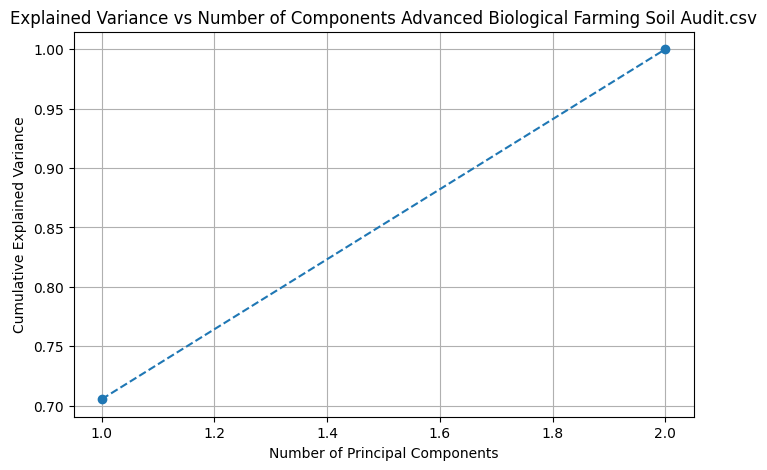

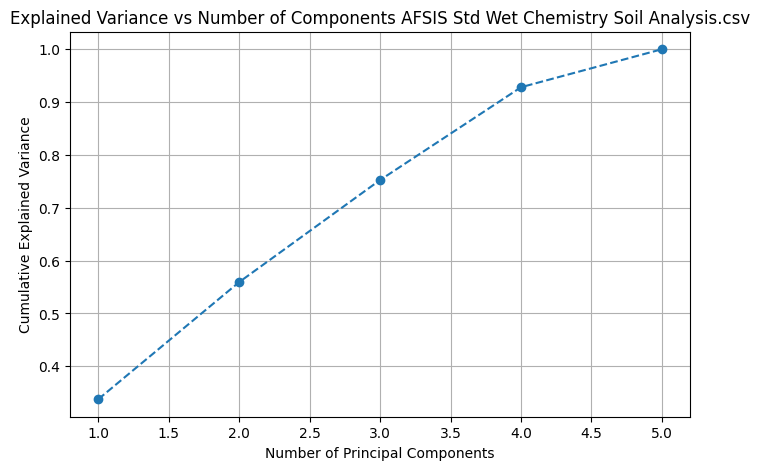

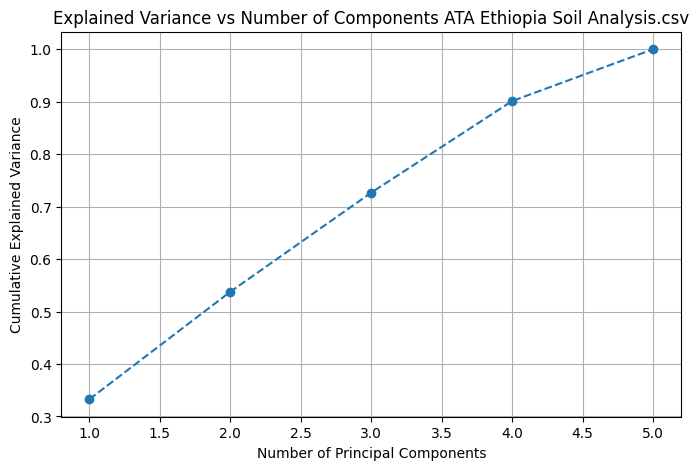

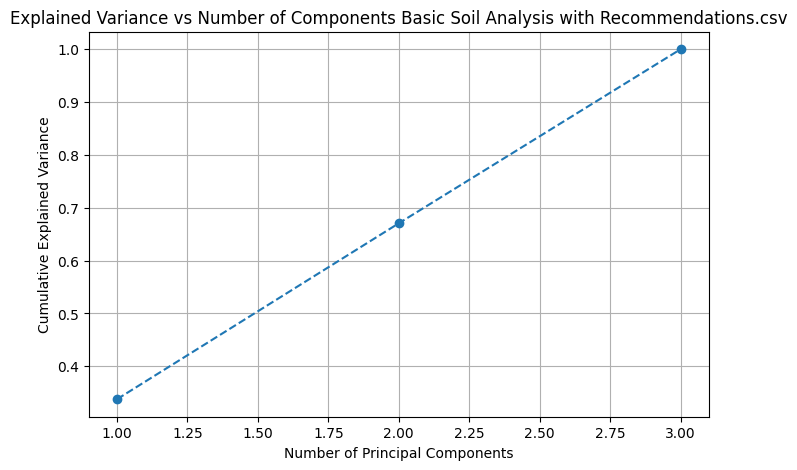

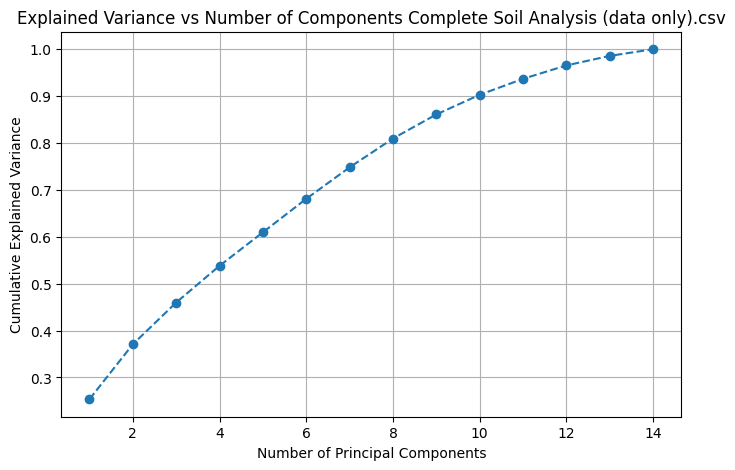

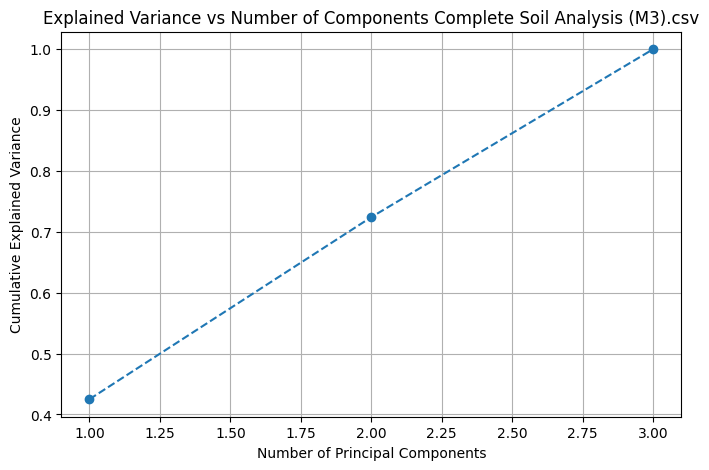

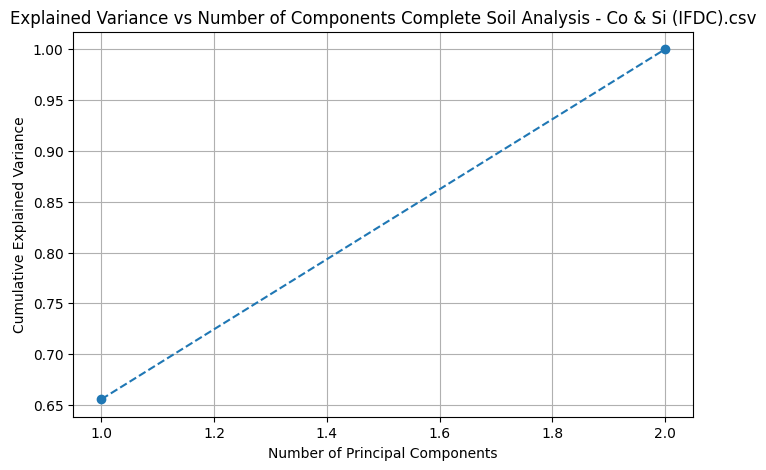

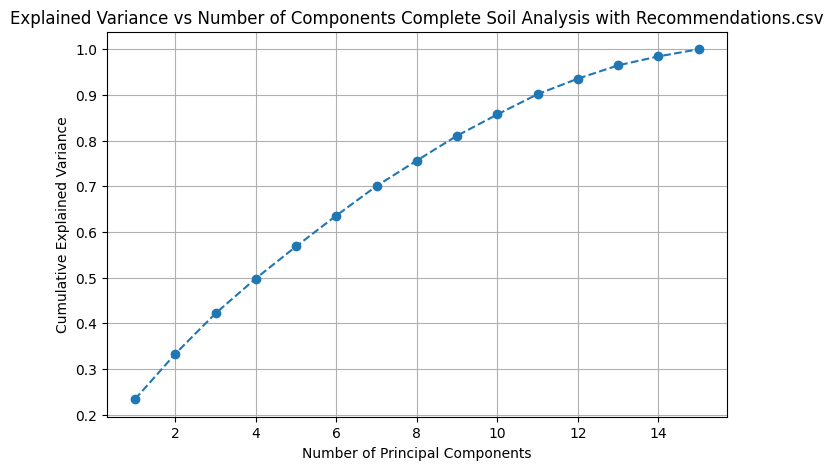

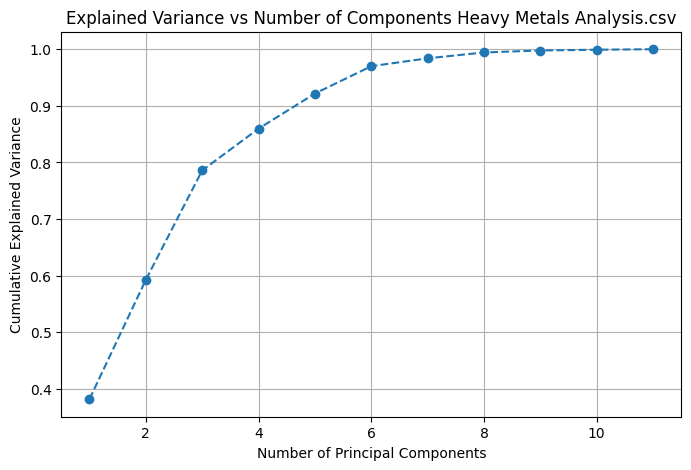

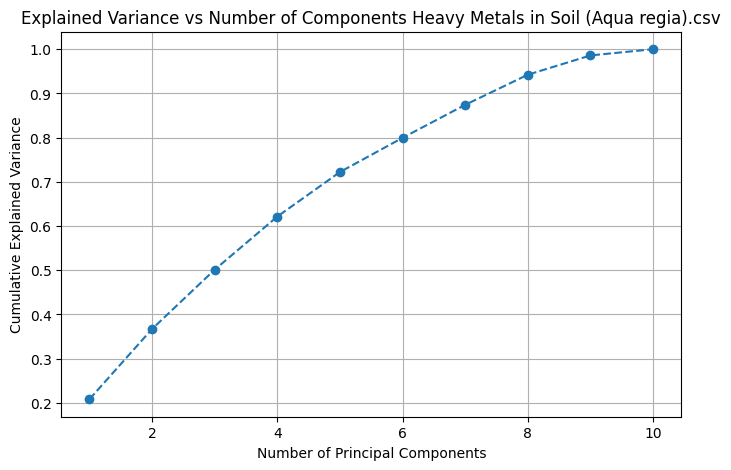

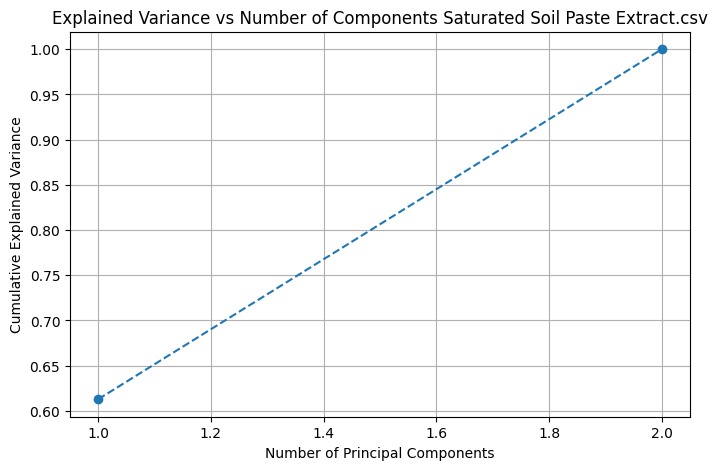

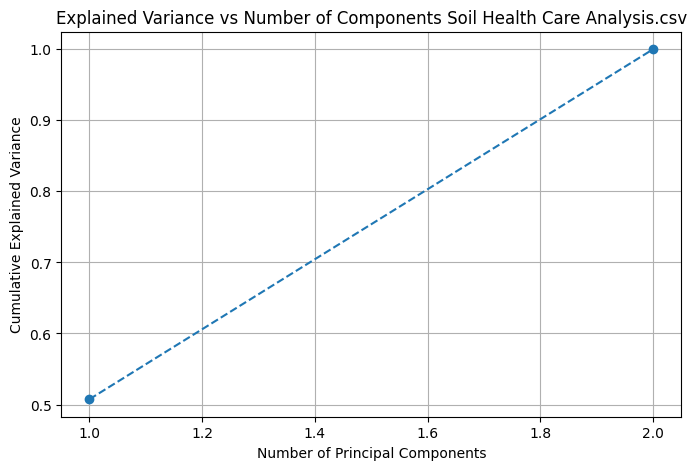

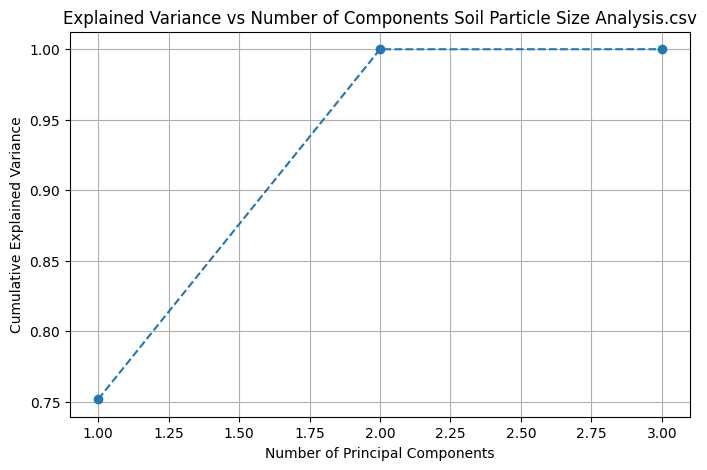

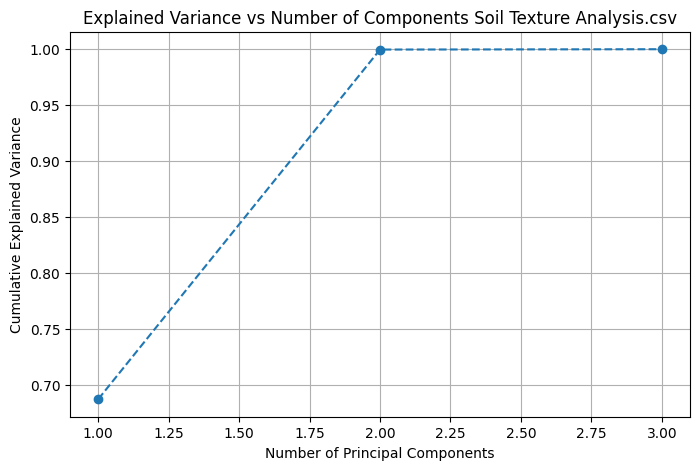

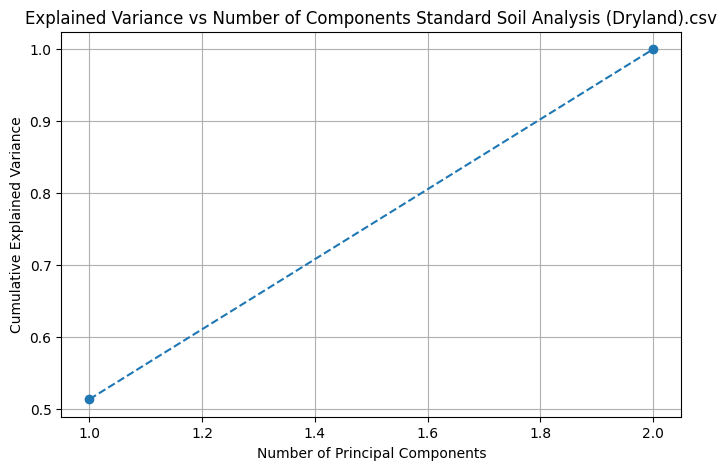

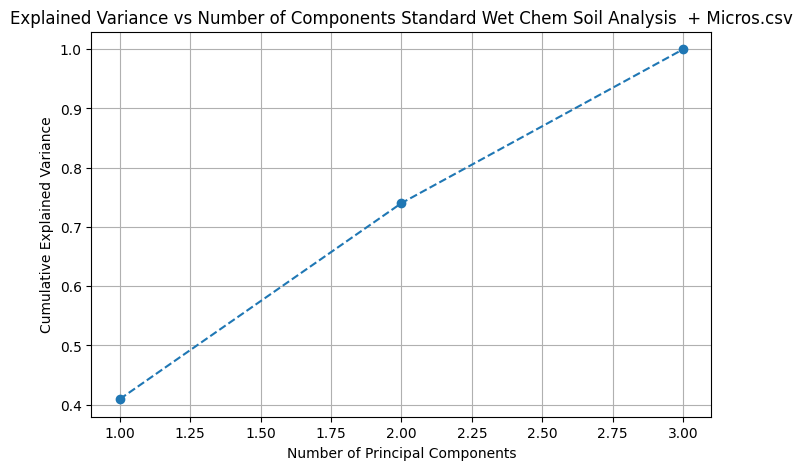

In [23]:
for analysis_file in os.listdir("output/analysis"):
    print(analysis_file)
    analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
    analysis_df = analysis_df.loc[analysis_df.index.isin(soil_df.sample_code)]
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    # analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)
    analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), index=analysis_df.index)
    analysis_df.to_csv(f"./output/analysis_imputed/{analysis_file}")
    pickle.dump(imp_mean, open(f"models/imputers/{analysis_file.replace('csv','pkl')}","wb"))
    # if(len(analysis_df) == 0):
    #     continue
    if(len(analysis_df.columns) == 1):
        continue
    sc = StandardScaler()
    pca = PCA()
    analysis_scaled = sc.fit_transform(analysis_df)
    pca.fit(analysis_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance vs Number of Components {analysis_file}')
    plt.grid(True)
    plt.savefig(f"./output/pca_plots/{analysis_file.replace('.csv','.png')}")
    n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f'Number of components explaining 95% variance: {n_components}')
    
    pca = PCA(n_components=n_components)
    pca_reduced_df = pca.fit_transform(analysis_scaled)
    analysis_scaled = pd.DataFrame(analysis_scaled,index=analysis_df.index)
    analysis_scaled.to_csv(f"output/analysis_scaled/{analysis_file}")
    np.save(f"output/pca_df/{analysis_file.replace('.csv','')}", pca_reduced_df)
    pickle.dump(sc, open(f"models/scalers/{analysis_file.replace('csv','pkl')}","wb"))
    pickle.dump(pca, open(f"models/pca/{analysis_file.replace('csv','pkl')}","wb"))

In [24]:
for analysis_file in os.listdir("output/pca_df"):
    print(analysis_file)
    pca_reduced_df = pd.DataFrame(np.load(f"output/pca_df/{analysis_file}"))
    if len(pca_reduced_df.columns) <= 2:
        continue
    mu = np.mean(pca_reduced_df, axis=0)
    sigma = np.cov(pca_reduced_df.T)
    pca_reduced_df['mahalanobis_distance'] = [distance.mahalanobis(pca_reduced_df.iloc[i], mu, np.linalg.inv(sigma)) for i in range(len(pca_reduced_df)) ]

    pd.DataFrame(pca_reduced_df).to_csv(f"output/mahalanobis_distance/{analysis_file.replace('.npy','')}.csv")

Advanced Biological Farming Soil Audit.npy
AFSIS Std Wet Chemistry Soil Analysis.npy
ATA Ethiopia Soil Analysis.npy
Basic Soil Analysis with Recommendations.npy
Complete Soil Analysis (data only).npy
Complete Soil Analysis (M3).npy
Complete Soil Analysis - Co & Si (IFDC).npy
Complete Soil Analysis with Recommendations.npy
Heavy Metals Analysis.npy
Heavy Metals in Soil (Aqua regia).npy
Saturated Soil Paste Extract.npy
Soil Health Care Analysis.npy
Soil Particle Size Analysis.npy
Soil Texture Analysis.npy
Standard Soil Analysis (Dryland).npy
Standard Wet Chem Soil Analysis  + Micros.npy


In [25]:
mahalanobis_threshold_dict = {}
for analysis_file in os.listdir("output/mahalanobis_distance"):
    print(analysis_file)
    analysis = analysis_file.replace(".csv","")
    mahalanobis_df = pd.read_csv(f"output/mahalanobis_distance/{analysis_file}",index_col=0)
    upper_quantile = (mahalanobis_df['mahalanobis_distance'].quantile(0.95))
    mahalanobis_threshold_dict[analysis_file.replace(".csv","")] = upper_quantile
    mahalanobis_df.loc[mahalanobis_df['mahalanobis_distance'] >= upper_quantile].to_csv(f"output/mahanobis_distance_upper_quantile/{analysis_file}")
    plt.boxplot(mahalanobis_df['mahalanobis_distance'])
    plt.axhline(y=upper_quantile, color='red', linestyle='--', label=f'Threshold at {upper_quantile}')
    plt.title(f"Mahalanobis Threshold = {round(upper_quantile,2)}")
    plt.savefig(f"output/mahalanobis_boxplots/{analysis}.png")
    plt.clf()
pickle.dump(mahalanobis_threshold_dict, open("mahalanobis_thresholds.dict","wb"))

AFSIS Std Wet Chemistry Soil Analysis.csv
ATA Ethiopia Soil Analysis.csv
Basic Soil Analysis with Recommendations.csv
Complete Soil Analysis (data only).csv
Complete Soil Analysis (M3).csv
Complete Soil Analysis with Recommendations.csv
Heavy Metals Analysis.csv
Heavy Metals in Soil (Aqua regia).csv
Standard Wet Chem Soil Analysis  + Micros.csv


<Figure size 640x480 with 0 Axes>

In [102]:
mahalanobis_threshold_dict

{'% Organic Matter (OM)': 2.4787498452162673,
 '% Soil Nitrogen (N)': 2.8604639465957726,
 'Advanced Biological Farming Soil Audit': 2.6277811147643377,
 'AFSIS Std Wet Chemistry Soil Analysis': 3.550887899802413,
 'ATA Ethiopia Soil Analysis': 2.407677942274546,
 'Available Nitrogen': 3.02263491528631,
 'Basic Soil Analysis (BSA)': 2.631981622753651,
 'Basic Soil Analysis with Recommendations': 2.6127442789597994,
 'Basic Soil Analysis': 2.6059185031458965,
 'Bio-available Nutrient Analysis': 2.6727884621670746,
 'Carbon Analysis': 2.9064009713000245,
 'Complete Soil + Bio-available Nutrients Analysis': 2.2812465755613838,
 'Complete Soil +Hp Analysis': 3.046286458594179,
 'Complete Soil Analysis (Calcareous)': 2.8073289689165652,
 'Complete Soil Analysis (data only)': 2.373410937682215,
 'Complete Soil Analysis (M3)': 3.557909535958923,
 'Complete Soil Analysis - Co & Si (IFDC)': 2.599494670364461,
 'Complete Soil Analysis with Recommendations': 2.148327689493776,
 'Complete Soil Ana

In [26]:
pd.DataFrame({'analysis_name':(mahalanobis_threshold_dict.keys())}).to_csv("output/analysis_names_send_to_thomas_and_josephine.csv")

In [28]:
conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [29]:
reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']
reverse_analysis_dict

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_23012\3771434913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']


{'% Gypsum': 540,
 '% Nitrogen (RSSP 2)': 647,
 '% Organic Matter': 258,
 '% Organic Matter (RSSP 2)': 646,
 '% Soil Nitrogen': 18,
 '%Assay': 27490,
 '%N (RSSP 2)': 652,
 '%OM (RSSP 2)': 651,
 '%P,%S Analysis(Super Calcium)': 383,
 '1:2 Soil Volume Extract': 294,
 '1:2 soil volume extract': 25,
 '1:2 Soil Volume Extract (Data Only)': 27339,
 '1:2 Vol Extract for BLGG': 317,
 '20:12:12 (N,P205,K20) Analysis': 840,
 'Absorbance at 254nm': 26936,
 'Acid Detergent Fibre': 27063,
 'Acid Insoluble Ash': 27417,
 'Acid Insoluble Matter': 27108,
 'Acid titration': 26647,
 'Acid Value': 26971,
 'Advanced Biological Farming Soil Audit': 26521,
 'Advanced Soil Health Analysis': 27181,
 'Aerobic Mesophilic Count': 26649,
 'Aflatoxin': 26794,
 'Aflatoxin AFB1': 26938,
 'Aflatoxin B1': 26939,
 'Aflatoxin in feed': 767,
 'Aflatoxin M1': 27469,
 'Aflatoxin Total': 766,
 'AfSIS Standard Leaf Analysis': 633,
 'AFSIS Std Wet Chemistry Soil Analysis': 589,
 'Aggregate Stability': 26727,
 'Agrifi Soil Micr

In [30]:
new_samples = pd.read_sql(f"SELECT sample_code, batch_date, result, unit_name, chemical_name, analysis_name FROM SampleResults WHERE sample_code IN {tuple(new_samples_df.sample_code.values)}", con=conn_lims)

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_23012\1881003016.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  new_samples = pd.read_sql(f"SELECT sample_code, batch_date, result, unit_name, chemical_name, analysis_name FROM SampleResults WHERE sample_code IN {tuple(new_samples_df.sample_code.values)}", con=conn_lims)


In [33]:
new_samples

sample_code          batch_date result unit_name   chemical_name  \
2      CB044SA0639 2024-06-07 15:23:00   23.7       ppm          Copper   
3      CB044SA0642 2024-06-07 15:23:00   19.6       ppm            Zinc   
4      CB044SA0642 2024-06-07 15:23:00   33.2  meq/100g           C.E.C   
5      CB044SA0642 2024-06-07 15:23:00   0.14         %  Total Nitrogen   
6      CB044SA0642 2024-06-07 15:23:00   1.53         %  Organic Carbon   
...            ...                 ...    ...       ...             ...   
83417  CB044SA0638 2024-06-07 15:23:00   1.47       ppm           Boron   
83418  CB044SA0638 2024-06-07 15:23:00   24.9       ppm          Copper   
83419  CB044SA0638 2024-06-07 15:23:00   13.3       ppm            Zinc   
83420  CB044SA0638 2024-06-07 15:23:00   38.9  meq/100g           C.E.C   
83421  CB044SA0638 2024-06-07 15:23:00   0.16         %  Total Nitrogen   

                                     analysis_name  
2      Complete Soil Analysis with Recommendations  
3      Complete Soil Analysis with Recommendations  
4      Complete Soil Analysis with Recommendations  
5      Complete Soil Analysis with Recommendations  
6      Complete Soil Analysis with Recommendations  
...                                            ...  
83417  Complete Soil Analysis with Recommendations  
83418  Complete Soil Analysis with Recommendations  
83419  Complete Soil Analysis with Recommendations  
83420  Complete Soil Analysis with Recommendations  
83421  Complete Soil Analysis with Recommendations  

[71892 rows x 6 columns]

In [34]:
new_samples = new_samples.dropna(subset=['chemical_name','result','analysis_name'])
new_samples['analysis_name'] = [ str(i).replace(":","").split(",") for i in new_samples.analysis_name ]
new_samples = new_samples.explode("analysis_name")

In [35]:
new_samples['result'] = [ str(i).replace("<","").replace(">","").strip() for i in new_samples['result'] ]

In [36]:
new_samples.loc[(new_samples['result'] == "ND"), "result" ] = 0

In [41]:
new_samples = new_samples.loc[~(new_samples['result'] == "Detected") ]
new_samples = new_samples.loc[~(new_samples['result'] == "") ]

In [38]:
new_samples['unit_name'] = [ str(i).strip() for i in new_samples['unit_name'].values ]

In [39]:
new_samples['chemical_name'] = [ str(i).lower().replace(" ","_").replace("(","").replace(")","").replace(".","").strip() for i in new_samples['chemical_name'].values ]

In [42]:
new_samples['result'] = new_samples['result'].astype(float)

In [44]:
test = []
for sample in new_samples.sample_code.unique():
    res = {}
    tmp_ = new_samples.loc[new_samples.sample_code == sample]
    res['sample_code'] = sample
    print([ i for i in tmp_.analysis_name.unique() ])
    res['analysis_id'] = [ reverse_analysis_dict[i] for i in tmp_.analysis_name.unique() if i in reverse_analysis_dict.keys() ]
    for index,row in tmp_.iterrows():
        if row['result'] >= 0 :
            res[row['chemical_name']] = {'result': float(row['result']), 'units': str(row['unit_name'])}
        else:
            res[row['chemical_name']] = {'result': 0, 'units': row['unit_name']}
    test.append(res)    

['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Standard Soil Analysis (Dryland) ']
['Complete Soil Analysis with Recommendations']
['Routine Soil Chemistry Analysis (Alkaline)', 'Soil Texture Analysis']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis (data only)']
['Complete Soil Analysis with Recommendations']
['Basic Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis (data only)']
['Complete Soil Analysis (data only)']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Complete Soil Analysis with Recommendations']
['Comple

In [45]:
str(test).replace("'",'"')

'[{"sample_code": "CB044SA0639", "analysis_id": [221], "copper": {"result": 23.7, "units": "ppm"}, "zinc": {"result": 15.1, "units": "ppm"}, "cec": {"result": 35.9, "units": "meq/100g"}, "total_nitrogen": {"result": 0.14, "units": "%"}, "organic_carbon": {"result": 1.71, "units": "%"}, "organic_matter": {"result": 2.94, "units": "%"}, "c/n_ratio": {"result": 12.2, "units": "None"}, "ph": {"result": 7.7, "units": "None"}, "ec_salts": {"result": 226.0, "units": "uS/cm"}, "phosphorus_olsen": {"result": 77.2, "units": "ppm"}, "potassium": {"result": 1280.0, "units": "ppm"}, "calcium": {"result": 5190.0, "units": "ppm"}, "magnesium": {"result": 618.0, "units": "ppm"}, "sulphur": {"result": 36.4, "units": "ppm"}, "sodium": {"result": 52.9, "units": "ppm"}, "iron": {"result": 101.0, "units": "ppm"}, "manganese": {"result": 290.0, "units": "ppm"}, "boron": {"result": 1.39, "units": "ppm"}}, {"sample_code": "CB044SA0642", "analysis_id": [221], "zinc": {"result": 19.6, "units": "ppm"}, "cec": {"

In [51]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/soil_unit_per_chemical_decision.csv")
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

result = {}
_df = _.explode('analysis_id', ignore_index=True)
import math
for index,row in _df.iterrows():
    try:
        row['phosphorus'] = row['phosphorus_olsen']
    except Exception as e:
        pass
    try:
        row['phosphorus_olsen'] = row['phosphorus']
    except Exception as e:
        pass
    sample_code = row['sample_code']
    if sample_code not in result.keys():
        result[sample_code] = []
    if math.isnan(row['analysis_id']):
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in specified", "details": f"Analysis id not provided", "analysis": None  })   
        continue
    try:
        row['analysis_name'] = analysis_dict[row['analysis_id']]
    except:
        pass
    analysis = row['analysis_name']
    analysis_id = row['analysis_id']
    if analysis not in mahalanobis_thresholds.keys():
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in models", "details": f"Analysis: {analysis} is not in the list of defined models", "analysis": row['analysis_name'] })   
        continue  
    row = row.dropna()
    scaler = pickle.load(open(f"models/scalers/{analysis}.pkl","rb"))
    pca = pickle.load(open(f"models/pca/{analysis}.pkl","rb"))
    imputer = pickle.load(open(f"models/imputers/{analysis}.pkl","rb"))
    analysis_df = pd.read_csv(f"output/analysis/{analysis}.csv",index_col=0)
    mahalanobis_distance_df = pd.read_csv(f"output/mahalanobis_distance/{analysis}.csv",index_col=0).drop("mahalanobis_distance",axis=1)

    

    try :
        tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    except Exception as e:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Missing parameters for analysis: {analysis}", "details": f"Missing parameters: {','.join([ i for i in analysis_df.columns if i not in row.dropna().index])} for analysis: {analysis}", "analysis": row['analysis_name']})
        continue
    failed_units_comparison = {}    
    for col in tmp_df.columns:
        expected_units = unit_decision.loc[(unit_decision['analysis_name'] == analysis) & (unit_decision['chemical_name'] == col)]
        
        import math
        if type(row[col]) != dict and math.isnan(row[col]):
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = None
        elif row[col]['units'] !=   expected_units['unit_name'].values[0] :
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = row[col]['units']
        else:
            continue    
    if len(failed_units_comparison.keys()) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Wrong units provided", "details": f"Expected units are {str(failed_units_comparison)} for analysis: {analysis}" , "analysis": row['analysis_name']})
        continue
    for col in analysis_df.columns:
        if type(row[col]) == dict:
            row[col] = row[col]['result']
    
    out_of_bounds_chems = [ ]
    for col in tmp_df.columns:
        if col == "sample_code":
            continue
        if col == "ec_salts":
            if row[col] > 105 or row[col] < 95:
                out_of_bounds_chems.append("ec_salts out of bounds. Allowed bounds are 95 - 105")
        if col == "Charge Balance":
            if row[col] < -1:
                out_of_bounds_chems.append("Charge Balance out of bounds. Allowed lower boundary is -10. ")       
        elif col.lower() == "total suspended solids" and row['analysis_name'].lower() == "total suspended solids":
            if row[col] > 1:
                out_of_bounds_chems.append("total suspended solids out of bounds. If analysis is total suspended solids is <1 then total suspended solids check should be <1  . ")         
    if len(out_of_bounds_chems) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Out of bounds", "details": f"{'.'.join(out_of_bounds_chems)}", "analysis": row['analysis_name'] })
        continue    

    tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    tmp_df = imputer.transform(tmp_df)
    df_scaled = scaler.transform(tmp_df)
    df_pca = pd.DataFrame(pca.transform(df_scaled))
    
    df_pca.columns = [ i for i in df_pca.columns]
    mahalanobis_distance_df.columns = [ i for i in df_pca.columns]
    df_pca = pd.concat([df_pca, mahalanobis_distance_df])
    mu = np.mean(df_pca, axis=0)
    sigma = np.cov(df_pca.T)

    mahalanobis_distance = distance.mahalanobis(df_pca.iloc[0], mu, np.linalg.inv(sigma))

    expected_md = mahalanobis_thresholds[analysis]

    if mahalanobis_distance > expected_md:
        result[sample_code].append({"sample_code": sample_code,"status":"fail", "message": "Mahalanobis distance exceeds threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} exceeds threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
    else:
        result[sample_code].append({"sample_code": sample_code,"status":"pass","message": "Mahalanobis distance within threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} is within threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
          

KeyError: 'analysis_name'

In [52]:
result

{'CB044SA0639': [{'sample_code': 'CB044SA0639',
   'status': 'warning',
   'message': 'Wrong units provided',
   'details': "Expected units are {'ph': {'expected_units': 'mS/cm', 'units_provided': 'None'}} for analysis: Complete Soil Analysis with Recommendations",
   'analysis': 'Complete Soil Analysis with Recommendations'}],
 'CB044SA0642': [{'sample_code': 'CB044SA0642',
   'status': 'warning',
   'message': 'Wrong units provided',
   'details': "Expected units are {'ph': {'expected_units': 'mS/cm', 'units_provided': 'None'}} for analysis: Complete Soil Analysis with Recommendations",
   'analysis': 'Complete Soil Analysis with Recommendations'}],
 'CB044SA0640': [{'sample_code': 'CB044SA0640',
   'status': 'warning',
   'message': 'Wrong units provided',
   'details': "Expected units are {'ph': {'expected_units': 'mS/cm', 'units_provided': 'None'}} for analysis: Complete Soil Analysis with Recommendations",
   'analysis': 'Complete Soil Analysis with Recommendations'}],
 'CB044SA0

In [53]:
test

[{'sample_code': 'CB044SA0639',
  'analysis_id': [221],
  'copper': {'result': 23.7, 'units': 'ppm'},
  'zinc': {'result': 15.1, 'units': 'ppm'},
  'cec': {'result': 35.9, 'units': 'meq/100g'},
  'total_nitrogen': {'result': 0.14, 'units': '%'},
  'organic_carbon': {'result': 1.71, 'units': '%'},
  'organic_matter': {'result': 2.94, 'units': '%'},
  'c/n_ratio': {'result': 12.2, 'units': 'None'},
  'ph': {'result': 7.7, 'units': 'None'},
  'ec_salts': {'result': 226.0, 'units': 'uS/cm'},
  'phosphorus_olsen': {'result': 77.2, 'units': 'ppm'},
  'potassium': {'result': 1280.0, 'units': 'ppm'},
  'calcium': {'result': 5190.0, 'units': 'ppm'},
  'magnesium': {'result': 618.0, 'units': 'ppm'},
  'sulphur': {'result': 36.4, 'units': 'ppm'},
  'sodium': {'result': 52.9, 'units': 'ppm'},
  'iron': {'result': 101.0, 'units': 'ppm'},
  'manganese': {'result': 290.0, 'units': 'ppm'},
  'boron': {'result': 1.39, 'units': 'ppm'}},
 {'sample_code': 'CB044SA0642',
  'analysis_id': [221],
  'zinc': {

In [54]:
final_df = pd.DataFrame()
for i in result.keys():
    out_df = (pd.DataFrame(result[i]))
    final_df = pd.concat([final_df, out_df])

In [55]:
final_df.to_csv("test_results.csv")